# Clustering Prototype - Initial Version
## Sentence embedding, dimensionality reduction, feature selection, clustering, and explaining clusters.


This file will allow you to set variables to run clustering and explainability on a dataset. In the next cell, you will be able to:

1.   Specify a dataset
     - [IMDB Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) for sentiment analysis
     - [Customer Support Ticket Dataset](https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset)
2.   Specify an embedding method
     - Sentence-BERT ([paper](https://arxiv.org/abs/1908.10084), [documentation](https://www.sbert.net/))
     - LLM2Vec ([paper](https://arxiv.org/abs/2404.05961), [GitHub](https://github.com/McGill-NLP/llm2vec))
2.   Flag if you would like dimensionality reduction (PCA) to occur
3.   Flag if you would like feature selection (decision trees) to occur

Based on these options, the file will run K-means clustering and labeling on the dataset.

Finally, it will prompt an LLM to explain the cluster groupings.


## Set options for clustering

For each of the sections in the following cell, uncomment the option you wish to use for each section and ensure the rest are commented out.

In [2]:
# Dataset --------------------------------------------
dataset = "IMDB.csv"
text_col = "review"
label_col = "sentiment"
# dataset = "helpdesk_customer_tickets.csv"
# text_col =
# label_col =

# Embedding method -----------------------------------
method = "s_bert"
# method = "llm2vec"

# Dimensionality reduction (PCA) ---------------------
pca = True
# pca = False

# Feature selection (decision trees)  ----------------
decision_trees = True
# decision_trees = False

# Cluster count selection ----------------------------
cluster_count_method = "WCSS Elbow" 
# cluster_count_method = "Silhouette Score"
# cluster_count = 10

## Imports

Shivani note to venv/docker people: I didn't have to do these pip installs on Colab, but Kerria did for it to work on her PC:

!pip install transformers torch

!pip install -U sentence-transformers

(Disclaimer: only these were really needed to work on my (Kerria's) PC, but it'll probably vary from env to env.)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

/Users/kerria/Library/Python/3.8/lib/python/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
# Read dataset --------------------------------------------------------------
df = pd.read_csv(dataset)
df = df.sample(frac=0.05)
text = df[text_col]

# Calculate embeddings ------------------------------------------------------
# Note: this is a time-consuming step (~7 min)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(text.tolist(), convert_to_tensor=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# Dimensionality Reduction (PCA) --------------------------------------------
if pca:
  pca_model = PCA(n_components=2)
  embeddings_2d = pca_model.fit_transform(embeddings)

## Incorporate feature selection using decision trees

"Shrink" or drop the non-important features with respect to the output class, and "expand" the features that are more important to determining the output class.

In [9]:
# Feature Selection (Decision Trees) ----------------------------------------
if decision_trees:
  X_train, X_test, y_train, y_test = train_test_split(embeddings, df[label_col], random_state = 8, test_size = 0.3)

  # Fit the decision tree model
  decision_tree_model = DecisionTreeClassifier()
  decision_tree_model.fit(X_train, y_train)

  # Access feature importances
  feature_importances = decision_tree_model.feature_importances_

  # Delete low-importance features
  low_importance_indices = np.where(feature_importances < 0.025)[0] # random sampling prob. -- 1/384 = 0.0026
  embeddings_small = np.delete(embeddings, low_importance_indices, axis=1)
  X_train_reduced = np.delete(X_train, low_importance_indices, axis=1)
  X_test_reduced = np.delete(X_test, low_importance_indices, axis=1)
  print(f"Embeddings went from size {len(X_train[0])} to {len(X_train_reduced[0])}")

Embeddings went from size 384 to 4


## K-means clustering

First determine optimal number of clusters through either WCSS elbow point selection or silhouette score maximization.

/Users/kerria/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/kerria/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kerria/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: Futur

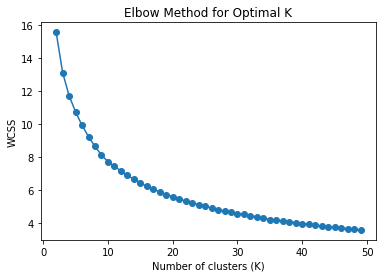

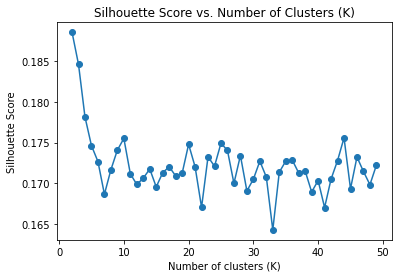

In [10]:

wcss_list = []  # within-cluster sum of squares
silhouette_scores_list = []

# Calculate WCSS for each K
upper_bound_k = 50
for k in range(2, upper_bound_k):  # Choosing range from 1 to 50 for demonstration
    # wcss
    kmeans_experiment = KMeans(n_clusters=k, random_state=0)
    kmeans_experiment.fit(embeddings_small)
    wcss_list.append(kmeans_experiment.inertia_)

    labels = kmeans_experiment.fit_predict(embeddings_small)
    score = silhouette_score(embeddings_small, labels)
    silhouette_scores_list.append(score)

# Plot the WCSS values
plt.plot(range(2, upper_bound_k), wcss_list, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores to find optimal K
plt.plot(range(2, upper_bound_k), silhouette_scores_list, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

Determine optimal k. Either maximize Silhouette Score or estimate elbow point of WCSS chart.

In [ ]:
if cluster_count_method == "Silhouette Score":
    max_index = np.argmax(silhouette_scores_list)
    num_clusters = max_index + 2 # index 0 corresponds to 2 clusters
elif cluster_count_method == "WCSS Elbow":
    # elbow point occurs when the difference of slopes of a point to its two neighbors is maximized
    neighbor_range = 3 # how many counts out to determine slopes
    neighbor_slope_difference = [abs(abs(wcss_list[i]-wcss_list[i+neighbor_range]) - abs(wcss_list[i-neighbor_range]-wcss_list[i])) 
                                 for i in range(neighbor_range,len(wcss_list)-neighbor_range)]
    max_index = np.argmax(silhouette_scores_list)
    num_clusters = max_index + neighbor_range + 1# index 0 corresponds to neighbor_range + 1 clusters



else: 
    if isinstance(cluster_count_method, int):
        num_clusters = cluster_count_method
    else:
        print("ERROR: must choose valid cluster_count_method")


# Perform K-means clustering
# num_clusters = 5  # Define the number of clusters you want
print(f"Chosen number of clusters: {num_clusters}\ncluster_count_method: {cluster_count_method}")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_small)

# Print WCCS (within-cluster sum of squares) metric
wcss = kmeans.inertia_
print("Within-Cluster Sum of Squares:", wcss)

# NOTE: not sure what to do about this piece below (plotting to determine ideal num clusters)

Chosen number of clusters: 2
cluster_count_method: Silhouette Score
Within-Cluster Sum of Squares: 15.582612991333008


/Users/kerria/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Find closest examples to cluster centroids

Currently, we are using cosine similarity to find the data point closest to the cluster centroids as a proxy for explaining or representing that cluster. We can also explore other ways (e.g. using LLMs) to explain clusters.

In [25]:
# For each cluster centroid, print the closest data point
corpus = list(df[text_col])
centroid_embeddings = kmeans.cluster_centers_
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings_small)
    closest_data_point = corpus[int(similarity_scores.argmax())]
    print(f"Centroid of cluster {i}:\n-----\n{closest_data_point}\n-----\n\n")

Centroid of cluster 0:
-----
The sound in this movie is a nightmare. That is the best I can say for this movie. Any chance of a good story is lost once this films starts. The premise of the film sounds good. A playboy who comes to terms with the people around him. The plot is predictable and very dull. The wet T-Shirt contest may be the worst scene I've ever watched and is almost worth watching in a Mystery Science type of deal. The sound is at times hard to hear and the main actor seems to not know how to speak clearly. His accent makes him very hard to understand. The only bright sport is the acting of Penelope Ann Miller. Her role is underdeveloped but she plays it well. In short, do not waste your time.
-----


Centroid of cluster 1:
-----
It must say something about the state of our nation that this programme is one of the most popular currently screened. <br /><br />The 'square' is peopled by such a miserable, untrustworthy, amoral, spiteful, unrelentingly dour group of character

In [27]:
# Print a few data points from each cluster to also help with explainability
for i in range(num_clusters):
    print(f"\n\n\nCluster {i}:")
    samples = df[df['cluster'] == i][text_col].tolist()[:5]
    for s in samples:
        print("--")
        print(s)
    print("--")




Cluster 0:
--
Latter Days for me was a very moving film, it showed just how hard and disrespected the gay community really is. The film etherizes true passion and really explores the feelings of these two characters, the film holds a real depth of compassion for the gay community, as it really speaks out for the gay man/woman. Personally i think it's about high time that the homosexual community of all religions should no longer hold there head in shame, just for being there beautiful self. The film was very much of a eye opener for me as I could not believe how anti homosexual this world really is. Even at schools if a kid dislikes something they will refer to it as being "gay". I real hope that more film like this one are made, and that they are not just labelled as a "Gay" film but as a love story, as I believe that gay directors should stick up for themselves and tell their story through their eyes.
--
Irwin Allen's first venture into all star spectacle was one all star disaster